# Subtask 2: Cascaded Two-Model Approach for Polarization Type Classification

This notebook implements multilingual polarization type classification using a **cascaded two-model architecture**.


Model 1 filters out non-polarized content to reduce false positives, while Model 2 focuses on distinguishing between polarization types using only polarized training data.

## 1. Environment Setup

In [1]:
# Install required packages
!pip install -q transformers datasets peft accelerate bitsandbytes
!pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm
!pip install -q iterative-stratification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 43.0 MB/s eta 0:00:00


In [2]:
import os
import gc
import json
import random
import warnings
import zipfile
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed
)

from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel
)

warnings.filterwarnings('ignore')

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA L4
GPU Memory: 23.80 GB


In [3]:
class Config:
    # Base Model
    MODEL_NAME = "xlm-roberta-base"

    # Model 1 Config (Binary Polarization Filter)
    MODEL1_LORA_R = 16
    MODEL1_LORA_ALPHA = 32
    MODEL1_LORA_DROPOUT = 0.1
    MODEL1_LEARNING_RATE = 2e-4
    MODEL1_NUM_EPOCHS = 5
    MODEL1_BATCH_SIZE = 32

    # Model 2 Config (Multi-label Type Classifier)
    MODEL2_LORA_R = 32
    MODEL2_LORA_ALPHA = 64
    MODEL2_LORA_DROPOUT = 0.05
    MODEL2_LEARNING_RATE = 1.5e-4
    MODEL2_NUM_EPOCHS = 5
    MODEL2_BATCH_SIZE = 32

    # Shared LoRA config
    LORA_TARGET_MODULES = ["query", "key", "value", "dense"]

    # Training configuration
    MAX_LENGTH = 256
    EVAL_BATCH_SIZE = 32
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01
    GRADIENT_ACCUMULATION_STEPS = 2

    # Data configuration
    VALIDATION_SPLIT = 0.1
    USE_ALL_LANGUAGES = True
    SELECTED_LANGUAGES = ["eng", "hin", "arb", "spa", "deu"]
    LABEL_COLUMNS = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

    # Class weighting
    USE_CLASS_WEIGHTS = True

    # Paths
    BASE_DIR = "/content"
    SUBTASK1_DIR = "/content/subtask1"
    SUBTASK2_DIR = "/content/subtask2"
    OUTPUT_DIR = "/content/output_cascaded_model"
    MODEL1_OUTPUT_DIR = "/content/output_cascaded_model/model1_filter"
    MODEL2_OUTPUT_DIR = "/content/output_cascaded_model/model2_classifier"

    # Inference threshold
    POLARIZATION_THRESHOLD = 0.5

    # Reproducibility
    SEED = 42

    # Device
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()
set_seed(config.SEED)
print(f"Device: {config.DEVICE}")
print(f"Model: {config.MODEL_NAME}")

Device: cuda
Model: xlm-roberta-base


## 2. Data Loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_DATASET_PATH = "/content/drive/MyDrive/Dataset"

if os.path.exists(DRIVE_DATASET_PATH):
    print(f"Dataset path: {DRIVE_DATASET_PATH}")
    for f in os.listdir(DRIVE_DATASET_PATH):
        print(f"  {f}")
else:
    print("Dataset folder not found.")

Mounted at /content/drive
Dataset path: /content/drive/MyDrive/Dataset
  subtask3
  subtask1
  subtask2
  .ipynb_checkpoints
  ita_test.csv
  subtask1.zip
  subtask2.zip


In [5]:
# Extract the zip files
def extract_zip(zip_path, extract_to):
    """Extract a zip file to the specified directory."""
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted to {extract_to}")

# Extract subtask1.zip
subtask1_zip = os.path.join(DRIVE_DATASET_PATH, "subtask1.zip")
if os.path.exists(subtask1_zip):
    extract_zip(subtask1_zip, config.BASE_DIR)
else:
    print(f"Warning: {subtask1_zip} not found")

# Extract subtask2.zip
subtask2_zip = os.path.join(DRIVE_DATASET_PATH, "subtask2.zip")
if os.path.exists(subtask2_zip):
    extract_zip(subtask2_zip, config.BASE_DIR)
else:
    print(f"Warning: {subtask2_zip} not found")

# Verify extraction
print("\nVerifying extracted directories:")
for d in [config.SUBTASK1_DIR, config.SUBTASK2_DIR]:
    if os.path.exists(d):
        train_path = os.path.join(d, "train")
        if os.path.exists(train_path):
            files = os.listdir(train_path)
            print(f"  {d}/train: {len(files)} files")
        else:
            print(f"  {d}: train folder not found")
    else:
        print(f"  {d}: NOT FOUND")

Extracting /content/drive/MyDrive/Dataset/subtask1.zip...
Extracted to /content
Extracting /content/drive/MyDrive/Dataset/subtask2.zip...
Extracted to /content

Verifying extracted directories:
  /content/subtask1/train: 22 files
  /content/subtask2/train: 22 files


In [6]:
def clean_text_column(df: pd.DataFrame, col_name: str = 'text') -> pd.DataFrame:
    df[col_name] = df[col_name].astype(str)
    df[col_name] = df[col_name].str.replace(r'[\n\r\t]', ' ', regex=True)
    df[col_name] = df[col_name].str.replace(r'\s+', ' ', regex=True)
    df[col_name] = df[col_name].str.strip()
    return df


def load_subtask1_data(data_dir: str, languages: Optional[List[str]] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_dir = Path(data_dir) / "train"
    all_files = list(train_dir.glob("*.csv"))

    print(f"Found {len(all_files)} files in {train_dir}")

    dataframes = []
    stats = []

    for file_path in tqdm(all_files, desc="Loading subtask1"):
        lang_code = file_path.stem

        if languages is not None and lang_code not in languages:
            continue

        try:
            df = pd.read_csv(file_path, quotechar='"', skipinitialspace=True, on_bad_lines='warn')

            if 'text' not in df.columns or 'polarization' not in df.columns:
                continue

            df = df.dropna(subset=['text', 'polarization'])
            df = clean_text_column(df, 'text')
            df['polarization'] = df['polarization'].astype(int)
            df['language'] = lang_code

            class_counts = df['polarization'].value_counts().to_dict()
            stats.append({
                'language': lang_code,
                'total': len(df),
                'class_0': class_counts.get(0, 0),
                'class_1': class_counts.get(1, 0)
            })

            dataframes.append(df)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    combined_df = pd.concat(dataframes, ignore_index=True)
    stats_df = pd.DataFrame(stats)

    print(f"Total samples: {len(combined_df)}")
    print(f"Languages: {combined_df['language'].nunique()}")
    print(f"Class distribution: {combined_df['polarization'].value_counts().to_dict()}")

    return combined_df, stats_df


def load_subtask2_data(data_dir: str, languages: Optional[List[str]] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_dir = Path(data_dir) / "train"
    all_files = list(train_dir.glob("*.csv"))

    print(f"Found {len(all_files)} files in {train_dir}")

    dataframes = []
    stats = []

    for file_path in tqdm(all_files, desc="Loading subtask2"):
        lang_code = file_path.stem

        if languages is not None and lang_code not in languages:
            continue

        try:
            df = pd.read_csv(file_path, quotechar='"', skipinitialspace=True, on_bad_lines='warn')

            required_cols = ['text'] + config.LABEL_COLUMNS
            missing_cols = [c for c in required_cols if c not in df.columns]
            if missing_cols:
                continue

            df = df.dropna(subset=['text'])
            df = clean_text_column(df, 'text')
            df['language'] = lang_code

            for col in config.LABEL_COLUMNS:
                df[col] = df[col].fillna(0).astype(int)

            df['polarization'] = (df[config.LABEL_COLUMNS].sum(axis=1) > 0).astype(int)

            file_stats = {'language': lang_code, 'total_samples': len(df)}
            for col in config.LABEL_COLUMNS:
                file_stats[col] = df[col].sum()
            file_stats['polarized'] = df['polarization'].sum()

            stats.append(file_stats)
            dataframes.append(df)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    combined_df = pd.concat(dataframes, ignore_index=True)
    stats_df = pd.DataFrame(stats)

    print(f"Total samples: {len(combined_df)}")
    print(f"Polarized: {combined_df['polarization'].sum()}")
    print(f"Non-polarized: {len(combined_df) - combined_df['polarization'].sum()}")

    return combined_df, stats_df


def load_dev_data(data_dir: str) -> pd.DataFrame:
    dev_dir = Path(data_dir) / "dev"
    all_files = list(dev_dir.glob("*.csv"))
    dataframes = []

    for file_path in tqdm(all_files, desc="Loading dev"):
        lang_code = file_path.stem
        try:
            df = pd.read_csv(file_path, quotechar='"', skipinitialspace=True, on_bad_lines='warn')
            if 'text' not in df.columns:
                continue
            df = clean_text_column(df, 'text')
            df['language'] = lang_code
            dataframes.append(df)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Loaded {len(combined_df)} dev samples")
    return combined_df

In [7]:
# Load subtask1 data (for Model 1)
print("Loading Subtask 1 data...")
if config.USE_ALL_LANGUAGES:
    subtask1_df, subtask1_stats = load_subtask1_data(config.SUBTASK1_DIR)
else:
    subtask1_df, subtask1_stats = load_subtask1_data(config.SUBTASK1_DIR, config.SELECTED_LANGUAGES)

# Load subtask2 data (for Model 2)
print("\nLoading Subtask 2 data...")
if config.USE_ALL_LANGUAGES:
    subtask2_df, subtask2_stats = load_subtask2_data(config.SUBTASK2_DIR)
else:
    subtask2_df, subtask2_stats = load_subtask2_data(config.SUBTASK2_DIR, config.SELECTED_LANGUAGES)

# Load dev data
print("\nLoading dev data...")
dev_df = load_dev_data(config.SUBTASK2_DIR)

Loading Subtask 1 data...
Found 22 files in /content/subtask1/train


Loading subtask1:   0%|          | 0/22 [00:00<?, ?it/s]

Total samples: 73681
Languages: 22
Class distribution: {1: 39145, 0: 34536}

Loading Subtask 2 data...
Found 22 files in /content/subtask2/train


Loading subtask2:   0%|          | 0/22 [00:00<?, ?it/s]

Total samples: 73681
Polarized: 39145
Non-polarized: 34536

Loading dev data...


Loading dev:   0%|          | 0/22 [00:00<?, ?it/s]

Loaded 3687 dev samples


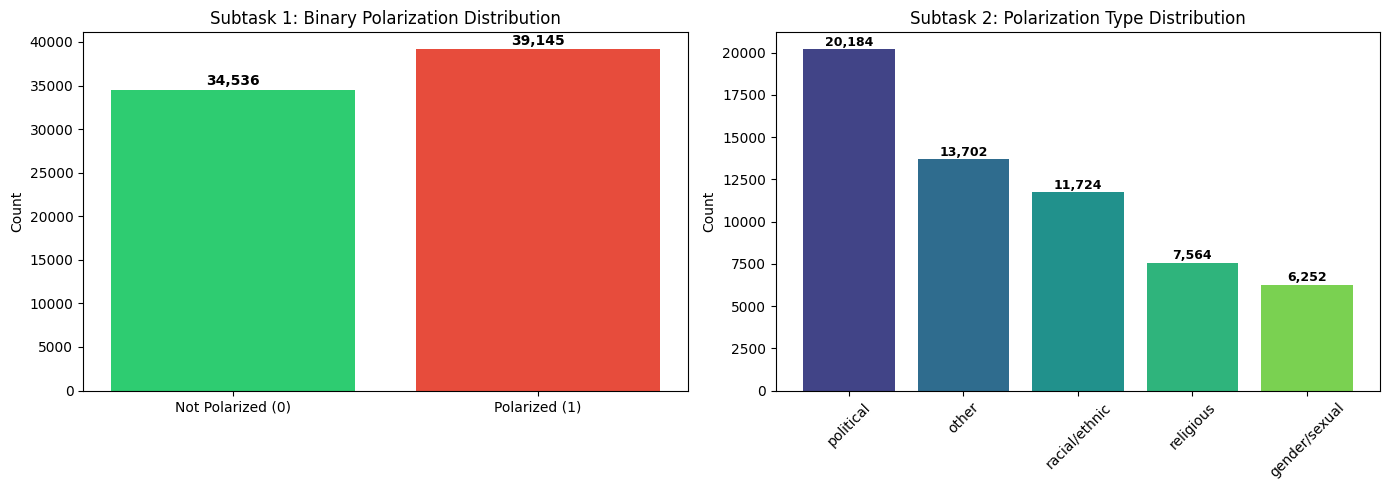

In [8]:
# Visualize data distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subtask 1: Binary polarization distribution
ax1 = axes[0]
counts = subtask1_df['polarization'].value_counts()
bars = ax1.bar(['Not Polarized (0)', 'Polarized (1)'], [counts.get(0, 0), counts.get(1, 0)],
               color=['#2ecc71', '#e74c3c'])
ax1.set_title('Subtask 1: Binary Polarization Distribution')
ax1.set_ylabel('Count')
for bar, val in zip(bars, [counts.get(0, 0), counts.get(1, 0)]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
             f'{val:,}', ha='center', fontweight='bold')

# Subtask 2: Multi-label distribution
ax2 = axes[1]
label_counts = subtask2_df[config.LABEL_COLUMNS].sum().sort_values(ascending=False)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(label_counts)))
bars = ax2.bar(label_counts.index, label_counts.values, color=colors)
ax2.set_title('Subtask 2: Polarization Type Distribution')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, label_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
             f'{val:,}', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

## 3. Prepare Training Data for Both Models

In [9]:
# Prepare data for Model 1 (Binary Filter)
print("Preparing Model 1 data...")

model1_train, model1_val = train_test_split(
    subtask1_df,
    test_size=config.VALIDATION_SPLIT,
    random_state=config.SEED,
    stratify=subtask1_df['polarization']
)

print(f"Model 1 Train: {len(model1_train)}")
print(f"Model 1 Val: {len(model1_val)}")
print(f"Class distribution: {model1_train['polarization'].value_counts().to_dict()}")

Preparing Model 1 data...
Model 1 Train: 66312
Model 1 Val: 7369
Class distribution: {1: 35230, 0: 31082}


In [10]:
# Prepare data for Model 2 (Type Classifier) - only polarized samples
print("Preparing Model 2 data (polarized only)...")

polarized_df = subtask2_df[subtask2_df['polarization'] == 1].copy()

print(f"Total polarized samples: {len(polarized_df)}")
for col in config.LABEL_COLUMNS:
    count = polarized_df[col].sum()
    pct = count / len(polarized_df) * 100
    print(f"  {col}: {count} ({pct:.1f}%)")

# Multilabel stratified split
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=config.VALIDATION_SPLIT, random_state=config.SEED)

X = polarized_df.index
y = polarized_df[config.LABEL_COLUMNS].values

train_idx, val_idx = next(msss.split(X, y))

model2_train = polarized_df.iloc[train_idx].copy()
model2_val = polarized_df.iloc[val_idx].copy()

print(f"\nModel 2 Train: {len(model2_train)}")
print(f"Model 2 Val: {len(model2_val)}")

Preparing Model 2 data (polarized only)...
Total polarized samples: 39145
  political: 20184 (51.6%)
  racial/ethnic: 11724 (30.0%)
  religious: 7564 (19.3%)
  gender/sexual: 6252 (16.0%)
  other: 13702 (35.0%)

Model 2 Train: 35201
Model 2 Val: 3944


## 4. Dataset Classes

In [11]:
class BinaryPolarizationDataset(Dataset):
    """Dataset for Model 1: Binary polarization classification."""

    def __init__(self, texts: List[str], labels: Optional[List[int]], tokenizer, max_length: int = 256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
            return_tensors=None
        )

        item = {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        }

        if self.has_labels:
            item['labels'] = self.labels[idx]

        return item


class MultiLabelDataset(Dataset):
    """Dataset for Model 2: Multi-label polarization type classification."""

    def __init__(self, texts: List[str], labels: Optional[Union[List[List[int]], np.ndarray]],
                 tokenizer, max_length: int = 256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
            return_tensors=None
        )

        item = {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        }

        if self.has_labels:
            labels_vector = self.labels[idx]
            if hasattr(labels_vector, 'tolist'):
                item['labels'] = [float(x) for x in labels_vector.tolist()]
            else:
                item['labels'] = [float(x) for x in labels_vector]

        return item

## 5. Custom Trainers

In [12]:
class WeightedBinaryTrainer(Trainer):
    """Trainer for Model 1 with class weights for imbalanced binary classification."""

    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


class MultilabelTrainer(Trainer):
    """Trainer for Model 2 with pos_weights for imbalanced multi-label classification."""

    def __init__(self, pos_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.pos_weights is not None:
            weights = self.pos_weights.to(logits.device)
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=weights)
        else:
            loss_fct = nn.BCEWithLogitsLoss()

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [13]:
def compute_binary_metrics(eval_pred):
    """Metrics for Model 1 (binary classification)."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)

    f1_per_class = f1_score(labels, predictions, average=None)

    return {
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision,
        'recall_macro': recall,
        'accuracy': accuracy,
        'f1_class_0': f1_per_class[0],
        'f1_class_1': f1_per_class[1]
    }


def compute_multilabel_metrics(eval_pred):
    """Metrics for Model 2 (multi-label classification)."""
    logits, labels = eval_pred

    # Sigmoid to convert logits to probabilities
    probs = 1 / (1 + np.exp(-logits))
    predictions = (probs > 0.5).astype(int)

    f1_micro = f1_score(labels, predictions, average='micro')
    f1_macro = f1_score(labels, predictions, average='macro')
    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)
    accuracy = accuracy_score(labels, predictions)

    results = {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'accuracy': accuracy,
    }

    # Per-class F1
    f1_per_class = f1_score(labels, predictions, average=None, zero_division=0)
    for i, label_name in enumerate(config.LABEL_COLUMNS):
        results[f'f1_{label_name}'] = f1_per_class[i]

    # ROC-AUC
    try:
        roc_auc = roc_auc_score(labels, probs, average='macro')
        results['roc_auc'] = roc_auc
    except ValueError:
        results['roc_auc'] = 0.0

    return results

## 6. Train Model 1: Binary Polarization Filter

In [14]:
print("Training Model 1: Binary Polarization Filter")

tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

model1_train_dataset = BinaryPolarizationDataset(
    texts=model1_train['text'].tolist(),
    labels=model1_train['polarization'].tolist(),
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

model1_val_dataset = BinaryPolarizationDataset(
    texts=model1_val['text'].tolist(),
    labels=model1_val['polarization'].tolist(),
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

print(f"Train dataset: {len(model1_train_dataset)}")
print(f"Val dataset: {len(model1_val_dataset)}")

Training Model 1: Binary Polarization Filter


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Train dataset: 66312
Val dataset: 7369


In [15]:
# Compute class weights for Model 1
if config.USE_CLASS_WEIGHTS:
    class_weights_m1 = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=model1_train['polarization'].values
    )
    class_weights_m1 = torch.tensor(class_weights_m1, dtype=torch.float32).to(config.DEVICE)
    print(f"Model 1 Class weights: {class_weights_m1}")
else:
    class_weights_m1 = None

Model 1 Class weights: tensor([1.0667, 0.9411], device='cuda:0')


In [16]:
# Load and configure Model 1
print(f"\nLoading base model: {config.MODEL_NAME}")

model1 = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=2,
    id2label={0: "Not Polarized", 1: "Polarized"},
    label2id={"Not Polarized": 0, "Polarized": 1}
)

# Configure LoRA for Model 1
lora_config_m1 = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=config.MODEL1_LORA_R,
    lora_alpha=config.MODEL1_LORA_ALPHA,
    lora_dropout=config.MODEL1_LORA_DROPOUT,
    target_modules=config.LORA_TARGET_MODULES,
    bias="none",
    modules_to_save=["classifier"]
)

model1 = get_peft_model(model1, lora_config_m1)
model1.print_trainable_parameters()
model1 = model1.to(config.DEVICE)


Loading base model: xlm-roberta-base


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3,246,338 || all params: 281,291,524 || trainable%: 1.1541


In [17]:
# Training arguments for Model 1
os.makedirs(config.MODEL1_OUTPUT_DIR, exist_ok=True)

training_args_m1 = TrainingArguments(
    output_dir=config.MODEL1_OUTPUT_DIR,
    num_train_epochs=config.MODEL1_NUM_EPOCHS,
    learning_rate=config.MODEL1_LEARNING_RATE,
    per_device_train_batch_size=config.MODEL1_BATCH_SIZE,
    per_device_eval_batch_size=config.EVAL_BATCH_SIZE,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
    warmup_ratio=config.WARMUP_RATIO,
    weight_decay=config.WEIGHT_DECAY,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_dir=f"{config.MODEL1_OUTPUT_DIR}/logs",
    logging_steps=100,
    report_to="none",
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    save_total_limit=2,
    seed=config.SEED,
    data_seed=config.SEED,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors="pt")

# Create trainer for Model 1
trainer_m1 = WeightedBinaryTrainer(
    model=model1,
    args=training_args_m1,
    train_dataset=model1_train_dataset,
    eval_dataset=model1_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_binary_metrics,
    class_weights=class_weights_m1,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [18]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Starting Model 1 training...")
train_result_m1 = trainer_m1.train()

print("Model 1 training completed")
print(f"  Time: {train_result_m1.metrics['train_runtime']:.2f}s")
print(f"  Loss: {train_result_m1.metrics['train_loss']:.4f}")

Starting Model 1 training...


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Accuracy,F1 Class 0,F1 Class 1
1,0.479000,0.438763,0.791260,0.791109,0.796138,0.795121,0.791288,0.793668,0.788852
2,0.427400,0.418749,0.809251,0.809504,0.810096,0.811187,0.809336,0.805213,0.813289
3,0.384600,0.402332,0.817942,0.818531,0.817681,0.818397,0.818429,0.808529,0.827355
4,0.339300,0.403567,0.821013,0.821543,0.820740,0.821667,0.821414,0.812536,0.829490
5,0.320300,0.413600,0.821073,0.821728,0.820934,0.821241,0.821685,0.810608,0.831538


Model 1 training completed
  Time: 1151.70s
  Loss: 0.4106


In [19]:
print("Evaluating Model 1:")
eval_results_m1 = trainer_m1.evaluate()

print("\nModel 1 Results:")
for key, value in eval_results_m1.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")

Evaluating Model 1...



Model 1 Results:
  eval_loss: 0.4136
  eval_f1_macro: 0.8211
  eval_f1_weighted: 0.8217
  eval_precision_macro: 0.8209
  eval_recall_macro: 0.8212
  eval_accuracy: 0.8217
  eval_f1_class_0: 0.8106
  eval_f1_class_1: 0.8315
  eval_runtime: 8.7768
  eval_samples_per_second: 839.6010
  eval_steps_per_second: 26.3190
  epoch: 5.0000


In [20]:
# Save Model 1
model1.save_pretrained(f"{config.MODEL1_OUTPUT_DIR}/lora_adapter")
tokenizer.save_pretrained(f"{config.MODEL1_OUTPUT_DIR}/lora_adapter")

# Save Model 1 config
model1_config = {
    'model_name': config.MODEL_NAME,
    'lora_r': config.MODEL1_LORA_R,
    'lora_alpha': config.MODEL1_LORA_ALPHA,
    'max_length': config.MAX_LENGTH,
    'validation_f1_macro': eval_results_m1['eval_f1_macro'],
    'task': 'binary_polarization_filter'
}

with open(f"{config.MODEL1_OUTPUT_DIR}/model_config.json", 'w') as f:
    json.dump(model1_config, f, indent=2)

print(f"\nModel 1 saved to {config.MODEL1_OUTPUT_DIR}/lora_adapter")


Model 1 saved to /content/output_cascaded_model/model1_filter/lora_adapter


## 7. Train Model 2: Multi-label Polarization Type Classifier

In [21]:
# Clear GPU memory before training Model 2
del model1, trainer_m1
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Training Model 2: Multi-label Polarization Type Classifier")

# Create datasets for Model 2
model2_train_dataset = MultiLabelDataset(
    texts=model2_train['text'].tolist(),
    labels=model2_train[config.LABEL_COLUMNS].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

model2_val_dataset = MultiLabelDataset(
    texts=model2_val['text'].tolist(),
    labels=model2_val[config.LABEL_COLUMNS].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

print(f"Model 2 Train dataset: {len(model2_train_dataset)} ")
print(f"Model 2 Val dataset: {len(model2_val_dataset)} ")

Training Model 2: Multi-label Polarization Type Classifier
Note: Model 2 is trained ONLY on polarized samples
Model 2 Train dataset: 35201 (polarized only)
Model 2 Val dataset: 3944 (polarized only)


In [22]:
# Compute pos_weights for Model 2 (using only polarized data!)
if config.USE_CLASS_WEIGHTS:
    print("\nComputing pos_weights for Model 2 ")

    pos_counts = model2_train[config.LABEL_COLUMNS].sum().values
    total_samples = len(model2_train)
    neg_counts = total_samples - pos_counts

    pos_weights_m2 = neg_counts / np.maximum(pos_counts, 1)
    pos_weights_m2 = torch.tensor(pos_weights_m2, dtype=torch.float32).to(config.DEVICE)

    print(f"Pos weights for Model 2:")
    for col, w in zip(config.LABEL_COLUMNS, pos_weights_m2.cpu().numpy()):
        print(f"  {col}: {w:.2f}")
else:
    pos_weights_m2 = None


Computing pos_weights for Model 2 (polarized data only)...
Pos weights for Model 2:
  political: 0.94
  racial/ethnic: 2.34
  religious: 4.17
  gender/sexual: 5.26
  other: 1.85


In [23]:
# Load and configure Model 2
print(f"\nLoading base model: {config.MODEL_NAME}")

id2label = {idx: label for idx, label in enumerate(config.LABEL_COLUMNS)}
label2id = {label: idx for idx, label in enumerate(config.LABEL_COLUMNS)}

model2 = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=len(config.LABEL_COLUMNS),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)

# Configure LoRA for Model 2
lora_config_m2 = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=config.MODEL2_LORA_R,
    lora_alpha=config.MODEL2_LORA_ALPHA,
    lora_dropout=config.MODEL2_LORA_DROPOUT,
    target_modules=config.LORA_TARGET_MODULES,
    bias="none",
    modules_to_save=["classifier"]
)

model2 = get_peft_model(model2, lora_config_m2)
model2.print_trainable_parameters()
model2 = model2.to(config.DEVICE)


Loading base model: xlm-roberta-base


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 5,902,853 || all params: 283,950,346 || trainable%: 2.0788


In [24]:
# Training arguments for Model 2
os.makedirs(config.MODEL2_OUTPUT_DIR, exist_ok=True)

training_args_m2 = TrainingArguments(
    output_dir=config.MODEL2_OUTPUT_DIR,
    num_train_epochs=config.MODEL2_NUM_EPOCHS,
    learning_rate=config.MODEL2_LEARNING_RATE,
    per_device_train_batch_size=config.MODEL2_BATCH_SIZE,
    per_device_eval_batch_size=config.EVAL_BATCH_SIZE,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
    warmup_ratio=config.WARMUP_RATIO,
    weight_decay=config.WEIGHT_DECAY,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_dir=f"{config.MODEL2_OUTPUT_DIR}/logs",
    logging_steps=100,
    report_to="none",
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    save_total_limit=2,
    seed=config.SEED,
    data_seed=config.SEED,
)

# Create trainer for Model 2
trainer_m2 = MultilabelTrainer(
    model=model2,
    args=training_args_m2,
    train_dataset=model2_train_dataset,
    eval_dataset=model2_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_multilabel_metrics,
    pos_weights=pos_weights_m2,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [25]:
# Train Model 2
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Starting Model 2 training...")
train_result_m2 = trainer_m2.train()

print("Model 2 training completed")
print(f"  Time: {train_result_m2.metrics['train_runtime']:.2f}s")
print(f"  Loss: {train_result_m2.metrics['train_loss']:.4f}")

Starting Model 2 training...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Macro,Recall Macro,Accuracy,F1 Political,F1 Racial/ethnic,F1 Religious,F1 Gender/sexual,F1 Other,Roc Auc
1,0.652600,0.533436,0.749467,0.726583,0.661963,0.828667,0.517748,0.860796,0.729681,0.664439,0.671622,0.706376,0.910728
2,0.460400,0.450938,0.795967,0.783323,0.731261,0.848326,0.594067,0.874468,0.785004,0.800000,0.721763,0.735382,0.934670
3,0.423600,0.431773,0.798440,0.785470,0.737372,0.848543,0.608012,0.869721,0.788338,0.800738,0.715523,0.753031,0.939781
4,0.401900,0.420668,0.804743,0.789721,0.728764,0.867792,0.611055,0.885344,0.797401,0.788530,0.724599,0.752731,0.941885
5,0.368600,0.425234,0.806199,0.790986,0.732073,0.865440,0.614097,0.886189,0.792895,0.792067,0.727519,0.756263,0.942275


Model 2 training completed
  Time: 642.84s
  Loss: 0.4671


In [26]:
# Evaluate Model 2
print("Evaluating Model 2...")
eval_results_m2 = trainer_m2.evaluate()

print("\nModel 2 Results:")
for key, value in eval_results_m2.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")

Evaluating Model 2...



Model 2 Results:
  eval_loss: 0.4252
  eval_f1_micro: 0.8062
  eval_f1_macro: 0.7910
  eval_precision_macro: 0.7321
  eval_recall_macro: 0.8654
  eval_accuracy: 0.6141
  eval_f1_political: 0.8862
  eval_f1_racial/ethnic: 0.7929
  eval_f1_religious: 0.7921
  eval_f1_gender/sexual: 0.7275
  eval_f1_other: 0.7563
  eval_roc_auc: 0.9423
  eval_runtime: 4.8070
  eval_samples_per_second: 820.4780
  eval_steps_per_second: 25.7960
  epoch: 5.0000


In [27]:
# Save Model 2
model2.save_pretrained(f"{config.MODEL2_OUTPUT_DIR}/lora_adapter")
tokenizer.save_pretrained(f"{config.MODEL2_OUTPUT_DIR}/lora_adapter")

# Save Model 2 config
model2_config = {
    'model_name': config.MODEL_NAME,
    'lora_r': config.MODEL2_LORA_R,
    'lora_alpha': config.MODEL2_LORA_ALPHA,
    'max_length': config.MAX_LENGTH,
    'validation_f1_macro': eval_results_m2['eval_f1_macro'],
    'label_columns': config.LABEL_COLUMNS,
    'task': 'multilabel_polarization_type_classifier',
    'trained_on': 'polarized_samples_only'
}

with open(f"{config.MODEL2_OUTPUT_DIR}/model_config.json", 'w') as f:
    json.dump(model2_config, f, indent=2)

print(f"\nModel 2 saved to {config.MODEL2_OUTPUT_DIR}/lora_adapter")


Model 2 saved to /content/output_cascaded_model/model2_classifier/lora_adapter


## 8. Cascaded Inference Pipeline

In [28]:
class CascadedPolarizationClassifier:
    """
    Cascaded two-model classifier for polarization type classification.
    """

    def __init__(
        self,
        model1_path: str,
        model2_path: str,
        base_model_name: str,
        device: str = "cuda",
        polarization_threshold: float = 0.5
    ):
        self.device = device
        self.polarization_threshold = polarization_threshold
        self.label_columns = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

        print("Loading cascaded models...")

        # Load tokenizer (same for both models)
        self.tokenizer = AutoTokenizer.from_pretrained(model1_path)

        # Load Model 1 (Binary Filter)
        base_model1 = AutoModelForSequenceClassification.from_pretrained(
            base_model_name,
            num_labels=2
        )
        self.model1 = PeftModel.from_pretrained(base_model1, model1_path)
        self.model1 = self.model1.to(device)
        self.model1.eval()

        # Load Model 2 (Multi-label Classifier)
        base_model2 = AutoModelForSequenceClassification.from_pretrained(
            base_model_name,
            num_labels=len(self.label_columns),
            problem_type="multi_label_classification"
        )
        self.model2 = PeftModel.from_pretrained(base_model2, model2_path)
        self.model2 = self.model2.to(device)
        self.model2.eval()

        print("Models loaded")

    @torch.no_grad()
    def predict_batch(
        self,
        texts: List[str],
        batch_size: int = 32,
        max_length: int = 256
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Predict polarization types for a batch of texts.
        """
        all_polarized_flags = []
        all_type_predictions = []
        all_type_probabilities = []

        for i in tqdm(range(0, len(texts), batch_size), desc="Cascaded Inference"):
            batch_texts = texts[i:i+batch_size]

            # Tokenize
            encodings = self.tokenizer(
                batch_texts,
                truncation=True,
                max_length=max_length,
                padding=True,
                return_tensors='pt'
            )
            encodings = {k: v.to(self.device) for k, v in encodings.items()}

            # Step 1: Model 1 - Determine if polarized
            outputs1 = self.model1(**encodings)
            probs1 = torch.softmax(outputs1.logits, dim=1)
            polarized_probs = probs1[:, 1].cpu().numpy()
            is_polarized = (polarized_probs >= self.polarization_threshold).astype(int)

            # Step 2: Model 2 - Classify polarization types
            outputs2 = self.model2(**encodings)
            probs2 = torch.sigmoid(outputs2.logits).cpu().numpy()
            preds2 = (probs2 > 0.5).astype(int)

            # Apply cascade: non-polarized texts get all zeros
            for j in range(len(batch_texts)):
                if is_polarized[j] == 0:
                    preds2[j] = np.zeros(5, dtype=int)
                    probs2[j] = np.zeros(5, dtype=float)

            all_polarized_flags.extend(is_polarized)
            all_type_predictions.extend(preds2)
            all_type_probabilities.extend(probs2)

        return (
            np.array(all_polarized_flags),
            np.array(all_type_predictions),
            np.array(all_type_probabilities)
        )

    def predict_single(self, text: str, max_length: int = 256) -> Dict:
        """
        Predict polarization type for a single text.
        """
        polarized_flags, type_preds, type_probs = self.predict_batch(
            [text], batch_size=1, max_length=max_length
        )

        return {
            'text': text[:100] + '...' if len(text) > 100 else text,
            'is_polarized': bool(polarized_flags[0]),
            'polarization_types': {
                label: {
                    'prediction': int(type_preds[0][i]),
                    'probability': float(type_probs[0][i])
                }
                for i, label in enumerate(self.label_columns)
            }
        }

In [29]:
# Clean up training models and load inference pipeline
del model2, trainer_m2
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Initialize cascaded classifier
cascaded_classifier = CascadedPolarizationClassifier(
    model1_path=f"{config.MODEL1_OUTPUT_DIR}/lora_adapter",
    model2_path=f"{config.MODEL2_OUTPUT_DIR}/lora_adapter",
    base_model_name=config.MODEL_NAME,
    device=config.DEVICE,
    polarization_threshold=config.POLARIZATION_THRESHOLD
)

Loading cascaded models...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded


## 9. Evaluate Cascaded Model on Validation Data

In [30]:
# Evaluate on subtask2 validation data (includes both polarized and non-polarized)
print("Evaluating cascaded model on full validation set...")

# Get full validation data from subtask2 (not just polarized)
_, full_val_df = train_test_split(
    subtask2_df,
    test_size=config.VALIDATION_SPLIT,
    random_state=config.SEED,
    stratify=subtask2_df['polarization']
)

print(f"Full validation set: {len(full_val_df)} samples")
print(f"  Polarized: {full_val_df['polarization'].sum()}")
print(f"  Non-polarized: {len(full_val_df) - full_val_df['polarization'].sum()}")

Evaluating cascaded model on full validation set...
Full validation set: 7369 samples
  Polarized: 3915
  Non-polarized: 3454


In [31]:
# Run cascaded inference
val_texts = full_val_df['text'].tolist()
polarized_flags, type_predictions, type_probabilities = cascaded_classifier.predict_batch(
    val_texts,
    batch_size=config.EVAL_BATCH_SIZE,
    max_length=config.MAX_LENGTH
)

# Get ground truth labels
y_true = full_val_df[config.LABEL_COLUMNS].values
y_pred = type_predictions

# Calculate metrics
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

print("Cascaded Model Results:")
print(f"  F1 Micro: {f1_micro:.4f}")
print(f"  F1 Macro: {f1_macro:.4f}")
print(f"  Precision Macro: {precision_macro:.4f}")
print(f"  Recall Macro: {recall_macro:.4f}")
print(f"  Accuracy: {accuracy:.4f}")

# Per-class metrics
print("\nPer-Class F1 Scores:")
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
for label, f1 in zip(config.LABEL_COLUMNS, f1_per_class):
    print(f"  {label}: {f1:.4f}")

# Filter effectiveness
true_polarized = full_val_df['polarization'].values
filter_accuracy = accuracy_score(true_polarized, polarized_flags)
filter_f1 = f1_score(true_polarized, polarized_flags, average='macro')

print(f"\nFilter (Model 1) Performance:")
print(f"  Accuracy: {filter_accuracy:.4f}")
print(f"  F1 Macro: {filter_f1:.4f}")

Cascaded Inference:   0%|          | 0/231 [00:00<?, ?it/s]

Cascaded Model Results:
  F1 Micro: 0.7063
  F1 Macro: 0.6946
  Precision Macro: 0.6450
  Recall Macro: 0.7577
  Accuracy: 0.6831

Per-Class F1 Scores:
  political: 0.7725
  racial/ethnic: 0.6468
  religious: 0.7168
  gender/sexual: 0.6472
  other: 0.6894

Filter (Model 1) Performance:
  Accuracy: 0.8215
  F1 Macro: 0.8209


Per-Language F1 Macro Scores:
language  f1_macro  samples
     nep  0.841715      172
     zho  0.768847      432
     urd  0.755203      369
     khm  0.727576      651
     hin  0.722167      315
     mya  0.665099      294
     fas  0.660665      334
     tur  0.660626      240
     spa  0.639143      329
     ori  0.618667      187
     arb  0.575005      327
     rus  0.569482      351
     amh  0.528261      315
     pol  0.492026      281
     swa  0.489413      681
     deu  0.489167      304
     eng  0.455437      341
     ben  0.422265      339
     pan  0.402216      160
     tel  0.358945      230
     hau  0.273561      385
     ita  0.271941      332


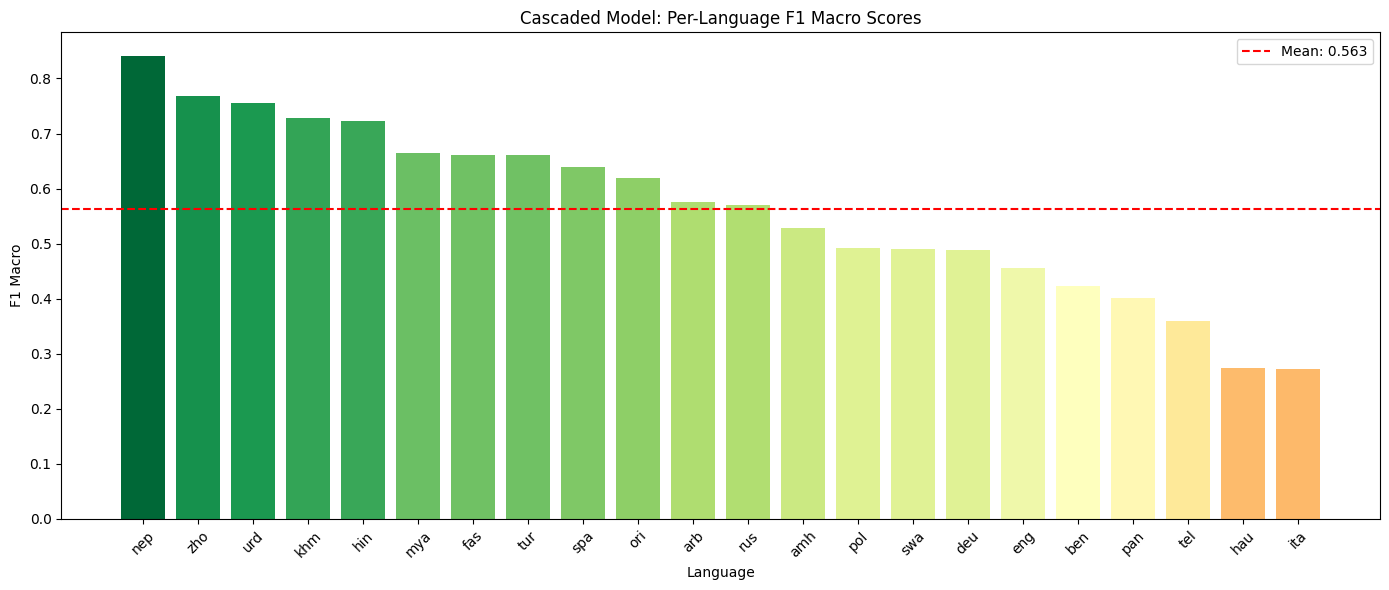

In [32]:
# Per-language evaluation
print("Per-Language F1 Macro Scores:")

full_val_df['predicted_' + config.LABEL_COLUMNS[0]] = type_predictions[:, 0]
for i, col in enumerate(config.LABEL_COLUMNS[1:], 1):
    full_val_df['predicted_' + col] = type_predictions[:, i]

results_per_lang = []
for lang in full_val_df['language'].unique():
    mask = full_val_df['language'] == lang
    lang_true = y_true[mask]
    lang_pred = y_pred[mask]

    if len(lang_pred) > 0:
        f1 = f1_score(lang_true, lang_pred, average='macro', zero_division=0)
        results_per_lang.append({'language': lang, 'f1_macro': f1, 'samples': mask.sum()})

results_df = pd.DataFrame(results_per_lang).sort_values('f1_macro', ascending=False)
print(results_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))
colors = plt.cm.RdYlGn(results_df['f1_macro'].values / results_df['f1_macro'].max())
bars = ax.bar(results_df['language'], results_df['f1_macro'], color=colors)
ax.axhline(y=results_df['f1_macro'].mean(), color='r', linestyle='--',
           label=f'Mean: {results_df["f1_macro"].mean():.3f}')
ax.set_xlabel('Language')
ax.set_ylabel('F1 Macro')
ax.set_title('Cascaded Model: Per-Language F1 Macro Scores')
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.savefig(f"{config.OUTPUT_DIR}/cascaded_f1_per_language.png", dpi=300)
plt.show()

## 10. Generate Predictions on Dev Set

In [33]:
# Generate predictions on dev set
print("Generating predictions on dev set...")

dev_texts = dev_df['text'].tolist()
dev_polarized, dev_type_preds, dev_type_probs = cascaded_classifier.predict_batch(
    dev_texts,
    batch_size=config.EVAL_BATCH_SIZE,
    max_length=config.MAX_LENGTH
)

print(f"Total samples: {len(dev_texts)}")
print(f"Predicted polarized: {dev_polarized.sum()}")
print(f"Predicted non-polarized: {len(dev_texts) - dev_polarized.sum()}")

Generating predictions on dev set...


Cascaded Inference:   0%|          | 0/116 [00:00<?, ?it/s]

Total samples: 3687
Predicted polarized: 1932
Predicted non-polarized: 1755


In [34]:
# Add predictions to dev dataframe
dev_df['predicted_polarized'] = dev_polarized
for i, col in enumerate(config.LABEL_COLUMNS):
    dev_df[col] = dev_type_preds[:, i]

# Save predictions in required format
os.makedirs(f"{config.OUTPUT_DIR}/dev_predictions", exist_ok=True)

# Save full predictions file
output_cols = ['id', 'text'] + config.LABEL_COLUMNS
dev_df[output_cols].to_csv(f"{config.OUTPUT_DIR}/dev_predictions/all_predictions.csv", index=False)

# Save per-language files
os.makedirs(f"{config.OUTPUT_DIR}/dev_predictions/by_language", exist_ok=True)
for lang in dev_df['language'].unique():
    lang_df = dev_df[dev_df['language'] == lang][output_cols]
    lang_df.to_csv(f"{config.OUTPUT_DIR}/dev_predictions/by_language/{lang}.csv", index=False)

print(f"\nPredictions saved to {config.OUTPUT_DIR}/dev_predictions/")


Predictions saved to /content/output_cascaded_model/dev_predictions/


In [35]:
# Show sample predictions
print("Sample Predictions:\n")

sample_languages = ['eng', 'hin', 'arb', 'spa']
for lang in sample_languages:
    if lang in dev_df['language'].values:
        print(f"{lang.upper()}:")
        lang_samples = dev_df[dev_df['language'] == lang].head(2)
        for _, row in lang_samples.iterrows():
            text_preview = row['text'][:80] + '...' if len(row['text']) > 80 else row['text']
            print(f"  Text: {text_preview}")
            print(f"  Polarized: {'Yes' if row['predicted_polarized'] else 'No'}")
            if row['predicted_polarized']:
                types = [col for col in config.LABEL_COLUMNS if row[col] == 1]
                print(f"  Types: {', '.join(types) if types else 'None'}")
            print()

Sample Predictions:

ENG:
  Text: God is with Ukraine and Zelensky
  Polarized: No

  Text: 4 Dems, 2 Republicans Luzerne County Council seatsDallas
  Polarized: No

HIN:
  Text: और इस तरह बीजेपी ने अपना इस्लामीकरण कर लिया
  Polarized: Yes
  Types: political, religious

  Text: ओरीजनल हिंदुत्व यही है ।
  Polarized: No

ARB:
  Text: حيل بيج يانذله تحجين ع العراقيات بس احنه العراقيات انشرفج وانشرف عشره مثلج
  Polarized: Yes
  Types: racial/ethnic

  Text: على زبي يا ليتها تجي معي البر اخليها تسوق دباب ما عليكم شباب لا تخافون علي بالبس...
  Polarized: No

SPA:
  Text: "puta weon, los progres arruinaron el indio picaro".
  Polarized: Yes
  Types: political, racial/ethnic

  Text: #mexico | el gobierno informo que esta dialogando con paises de #americalatina p...
  Polarized: No



## 11. Save Final Configuration

In [36]:
# Save final cascaded model configuration
cascaded_config = {
    'approach': 'cascaded_two_model',
    'description': 'Model 1 filters polarized/non-polarized, Model 2 classifies polarization types',
    'base_model': config.MODEL_NAME,
    'model1': {
        'task': 'binary_polarization_filter',
        'path': f"{config.MODEL1_OUTPUT_DIR}/lora_adapter",
        'lora_r': config.MODEL1_LORA_R,
        'lora_alpha': config.MODEL1_LORA_ALPHA,
        'learning_rate': config.MODEL1_LEARNING_RATE,
        'num_epochs': config.MODEL1_NUM_EPOCHS,
        'validation_f1_macro': eval_results_m1['eval_f1_macro']
    },
    'model2': {
        'task': 'multilabel_polarization_type_classifier',
        'path': f"{config.MODEL2_OUTPUT_DIR}/lora_adapter",
        'lora_r': config.MODEL2_LORA_R,
        'lora_alpha': config.MODEL2_LORA_ALPHA,
        'learning_rate': config.MODEL2_LEARNING_RATE,
        'num_epochs': config.MODEL2_NUM_EPOCHS,
        'trained_on': 'polarized_samples_only',
        'validation_f1_macro': eval_results_m2['eval_f1_macro']
    },
    'inference': {
        'polarization_threshold': config.POLARIZATION_THRESHOLD,
        'max_length': config.MAX_LENGTH,
        'label_columns': config.LABEL_COLUMNS
    },
    'cascaded_results': {
        'f1_macro': float(f1_macro),
        'f1_micro': float(f1_micro),
        'per_class_f1': {label: float(f1) for label, f1 in zip(config.LABEL_COLUMNS, f1_per_class)}
    }
}

with open(f"{config.OUTPUT_DIR}/cascaded_config.json", 'w') as f:
    json.dump(cascaded_config, f, indent=2)

print(f"\nCascaded model configuration saved to {config.OUTPUT_DIR}/cascaded_config.json")


Cascaded model configuration saved to /content/output_cascaded_model/cascaded_config.json


## Summary

### Model 1: Binary Polarization Filter
- Trained on Subtask 1 data (full dataset)
- Task: Binary classification (Polarized vs Not Polarized)

### Model 2: Multi-label Polarization Type Classifier
- Trained on Subtask 2 data (only polarized samples)
- Task: Multi-label classification (5 polarization types)

### Cascaded Pipeline
1. Input text passes through Model 1
2. If Model 1 predicts "Not Polarized" -> Output: [0,0,0,0,0]
3. If Model 1 predicts "Polarized" -> Model 2 classifies the type(s)